In [350]:
import numpy as np
from matplotlib import pyplot as plt
import astropy.units as u
from astropy import constants as const
import pandas as pd
from astropy.table import Column
from astropy.time import Time
from scipy import interpolate as interp
import time
# from Photoz import photoz_tools as phtz
from tractor import *
from skimage.transform import downscale_local_mean
import scipy.optimize as opt
import matplotlib as mpl
from scipy.spatial.distance import cdist

import itertools
import matplotlib.pyplot as plt
from astropy.table import hstack
import os

import SPHEREx_ObsSimulator as SPobs
from SPHEREx_Simulator_Tools import SPHEREx_Logger, data_filename
import SPHEREx_InstrumentSimulator as SPinst
import SPHEREx_SkySimulator as SPsky
from pkg_resources import resource_filename

# survey_plan_file = 'spherex_survey_plan_march_2021.fits'
survey_plan_file = "/Users/gemmahuai/Desktop/CalTech/SPHEREx/Redshift/spherex_survey_plan_R2.fits"
SPHEREx_Pointings = SPobs.Pointings(input_file = survey_plan_file,
                                   Gaussian_jitter=1.8, 
                                   roll_angle='psi2')

from spherex_parameters import load_spherex_parameters
# Load instrument and project parameters as a dictionary
spherex_parameters = load_spherex_parameters()


ds1 = 4
ds2 = 2
trim = 32
SPHEREx_Instrument = SPinst.Instrument(
    instrument_data=spherex_parameters,
    psf=data_filename("psf/simulated_PSF_database_centered_v3_og.fits"),
    psf_downsample_by_array={1: ds1, 2: ds1, 3: ds1, 4: ds2, 5: ds2, 6: ds2},
    psf_trim_by_array={1: trim, 2: trim, 3: trim, 4: trim, 5: trim, 6: trim},

    noise_model=SPinst.white_noise,
    dark_current_model=SPinst.poisson_dark_current,
    lvf_model=SPinst.Tabular_Bandpass()
)

from SPHEREx_SkySimulator import QuickCatalog
from SPHEREx_SkySimulator import Catalog_to_Simulate
# path='/Users/zhaoyuhuai/SPHEREx-Sky-Simulator/docs/QuickCatalog/'

from pyarrow import parquet
from astropy.table import Table
from astropy.io import fits
Channels = Table.read(data_filename('Channel_Definition_03022021.fits'))
Scene = SPsky.Scene(SPHEREx_Pointings,
                        zodi_model=SPsky.zodicalc.ModifiedKelsallModelWithHPFT())

COSMOS_tab = Table.read('/Users/gemmahuai/Desktop/CalTech/SPHEREx/SPHEREx_2023/COSMOS2020_FARMER_R1_v2.1_p3_in_Richard_sim_2023Dec4.fits', format='fits')
COSMOS_sim_sources = Table.read('/Users/gemmahuai/Desktop/CalTech/SPHEREx/SPHEREx_2023/COSMOS2020_FARMER_R1_v2.1_p3_in_Richard_sim_2023Dec4.fits', format='fits')



# Shuang-Shuang's deep field maps

In [351]:
import matplotlib.pyplot as plt
import matplotlib
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.visualization.wcsaxes import SphericalCircle
from astropy.coordinates import BarycentricMeanEcliptic, BarycentricTrueEcliptic
import healpy

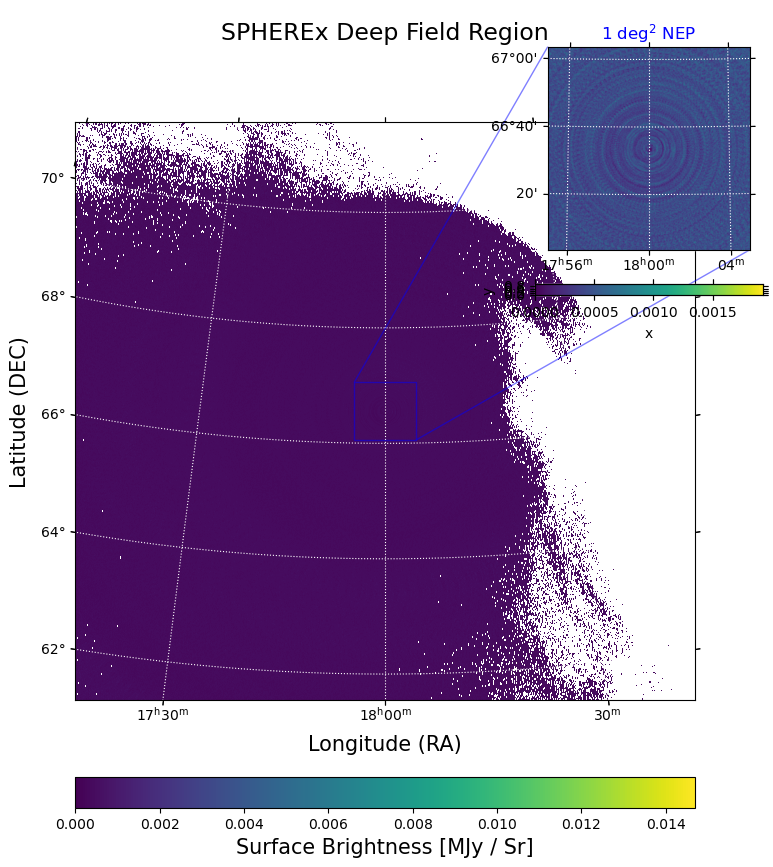

In [353]:

fits_file = "./maps/schen6/deep_north_dc.fits" 
with fits.open(fits_file) as hdul:
    data = hdul[0].data
    header = hdul[0].header

# extract wcs info
wcs = WCS(header)


fig = plt.figure(figsize=(8, 10))


ax1 = fig.add_subplot(111, projection=wcs) 
ax1.imshow(data, aspect='auto', origin="lower", cmap="viridis")
cbar = plt.colorbar(ax1.images[0], ax=ax1, location='bottom', pad=0.1)
cbar.set_label('Surface Brightness [MJy / Sr]', fontsize=15)

## plot a zoomed-in map
# inset axes....
# 1 square deg surrounding NEP
size = 0.5 # deg
x1 = int(header['CRPIX1'] - size/header['CDELT1'])
x2 = int(header['CRPIX1'] + size/header['CDELT1'])
y1 = int(header['CRPIX2'] - size/header['CDELT2'])
y2 = int(header['CRPIX2'] + size/header['CDELT2'])

data_zoom = np.zeros_like(data) + np.nanmedian(data)
data_zoom[y1:y2, x1:x2] = data[y1:y2, x1:x2].copy()

ticks = np.arange(x1, x2+dt, dt)
ticks_label = [f'{i}' for i in ticks]
axins = ax1.inset_axes(
    [0.7, 0.7, 0.45, 0.45],
    xlim=(x1, x2), ylim=(y1, y2), projection=wcs)
im = axins.imshow(data_zoom,  origin="lower", cmap="viridis")

divider = make_axes_locatable(axins)
cax = divider.new_vertical(size = "5%",
                           pad = 0.2,
                           pack_start = True)

fig.add_axes(cax, ticks = matplotlib.ticker.FixedLocator([]))
cbar1 = plt.colorbar(im, cax = cax, location='top', orientation = "horizontal", shrink=0.75)

axins.set_title(r'1 $\text{deg}^2$ NEP', color='blue')
axins.coords.grid(True, color='white', ls='dotted')
dt = int((x2-x1)/2) # ticking interval
ticks = np.arange(x1, x2+dt, dt)
ticks_label = [f'{i}' for i in ticks]
axins.coords[0].set_ticks(number=3)
axins.coords[1].set_ticks(number=3)
axins.coords[0].set_axislabel(" ")
axins.coords[1].set_axislabel(" ")

ax1.indicate_inset_zoom(axins, edgecolor="blue")


ax1.coords.grid(True, color="white", ls="dotted")
ax1.coords[0].set_axislabel(f"Longitude (RA)", fontsize=15)
ax1.coords[1].set_axislabel(f"Latitude (DEC)", fontsize=15)
ax1.set_title("SPHEREx Deep Field Region", fontsize=17)

plt.show()


In [348]:
header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 1140                                                  
NAXIS2  =                 1140                                                  
EXTEND  =                    T                                                  
WCSAXES =                    2 / Number of coordinate axes                      
CRPIX1  =                570.5 / Pixel coordinate of reference point            
CRPIX2  =                570.5 / Pixel coordinate of reference point            
CDELT1  =  0.00083333333333333 / [deg] Coordinate increment at reference point  
CDELT2  =  0.00083333333333333 / [deg] Coordinate increment at reference point  
CUNIT1  = 'deg'                / Units of coordinate increment and value        
CUNIT2  = 'deg'             

## Coadd maps

In [354]:
### check all maps ref point and resolution
map_list = ['./maps/schen6/deep_north_galaxies.fits', 
            './maps/schen6/deep_north_zodi.fits',
            './maps/schen6/deep_north_dc.fits',
            './maps/schen6/deep_north_read_noise.fits']

headers = []

for m in map_list:
    
    with fits.open(m) as hdul:
        
        header = hdul[0].header
        headers.append(header)
   

In [376]:
data1 = fits.getdata(map_list[i])
data2 = fits.getdata(map_list[j])

In [387]:
## given two maps, 
# determine which one is bigger
# check if the ref point is consistent
# on the bigger map, start from the ref point
# calc N pix spanned by the smaller map
# add together
i = 0
j = 2
bigger_idx = np.argmax([headers[i]['NAXIS1'], headers[j]['NAXIS1']])

assert np.isclose(headers[i]['CRVAL1'], headers[j]['CRVAL1'], rtol=1e-5) # check ref point RA
assert np.isclose(headers[i]['CRVAL2'], headers[j]['CRVAL2'], rtol=1e-5) # check ref point DEC
assert np.isclose(headers[i]['CDELT1'], headers[j]['CDELT1'], rtol=1e-5) # check map resolution
assert np.isclose(headers[i]['CDELT2'], headers[j]['CDELT2'], rtol=1e-5) # check map resolution

x0, y0 = (headers[j]['CRPIX1'], headers[j]['CRPIX2']) # central refpoint for the bigger map
dx = headers[i]['NAXIS1']//2 # smaller map Npix span
dy = headers[i]['NAXIS2']//2

# add the smaller map to the bigger map
data2[int(y0-dy):int(y0+dy), int(x0-dx):int(x0+dx)] += data1



In [408]:
## function to add two maps

def add_maps(maps, headers):
    
    # check which map is larger
    bigger_idx = np.argmax([headers[0]['NAXIS1'], headers[1]['NAXIS1']])
    smallr_idx = np.argmin([headers[0]['NAXIS1'], headers[1]['NAXIS1']])
    
    # ensure same coordinates
    assert np.isclose(headers[0]['CRVAL1'], headers[1]['CRVAL1'], rtol=1e-5) # check ref point RA
    assert np.isclose(headers[0]['CRVAL2'], headers[1]['CRVAL2'], rtol=1e-5) # check ref point DEC
    assert np.isclose(headers[0]['CDELT1'], headers[1]['CDELT1'], rtol=1e-5) # check map resolution
    assert np.isclose(headers[0]['CDELT2'], headers[1]['CDELT2'], rtol=1e-5) # check map resolution
    
    # set central reference point for the larger map
    x0, y0 = (headers[bigger_idx]['CRPIX1'], headers[bigger_idx]['CRPIX2']) 
    
    # calculate number of pixel span for the smaller map on the bigger map
    dx = headers[smallr_idx]['NAXIS1']//2 
    dy = headers[smallr_idx]['NAXIS2']//2
    
    # add the smaller map onto the larger one
    maps[bigger_idx][int(y0-dy):int(y0+dy), int(x0-dx):int(x0+dx)] += maps[smallr_idx]
    
    return maps[bigger_idx]




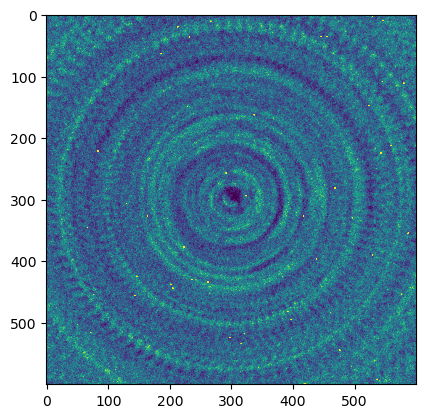

In [406]:
plt.imshow(data2[int(y0-dy+1500):int(y0+dy-1500), int(x0-dx+1500):int(x0+dx-1500)], vmax=0.001, vmin=0.0001)
# plt.xlim(5500,6500)
# plt.ylim(5500,6500)


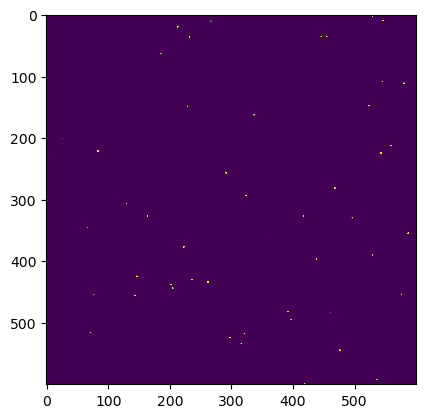

In [407]:
plt.imshow(data1[1500:2100, 1500:2100], vmax=0.001, vmin=0.0001)

In [404]:
len(data1)

3600

(1780.0, 1820.0)

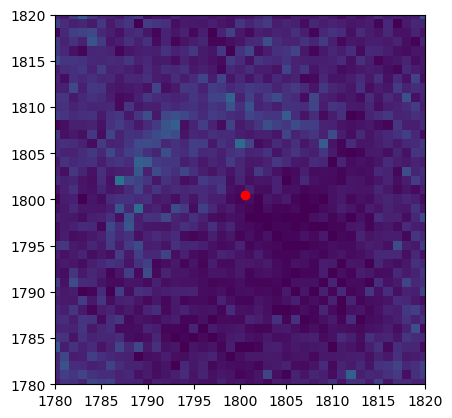

In [384]:
plt.imshow(data2[int(y0-dy):int(y0+dy), int(x0-dx):int(x0+dx)])
plt.scatter(1800.5, 1800.5, color='red')
plt.xlim(1780,1820)
plt.ylim(1780,1820)

In [151]:
sr_per_pix = (header['CDELT1']*np.pi/180) * (header['CDELT2']*np.pi/180)


In [359]:
##

[SIMPLE  =                    T / conforms to FITS standard                      
 BITPIX  =                  -64 / array data type                                
 NAXIS   =                    2 / number of array dimensions                     
 NAXIS1  =                 3600                                                  
 NAXIS2  =                 3600                                                  
 EXTEND  =                    T                                                  
 WCSAXES =                    2 / Number of coordinate axes                      
 CRPIX1  =               1800.5 / Pixel coordinate of reference point            
 CRPIX2  =               1800.5 / Pixel coordinate of reference point            
 CDELT1  =  0.00083333333333333 / [deg] Coordinate increment at reference point  
 CDELT2  =  0.00083333333333333 / [deg] Coordinate increment at reference point  
 CUNIT1  = 'deg'                / Units of coordinate increment and value        
 CUNIT2  = 'deg'